### Set GPU clocks

In [ ]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

In [1]:
from utils import *

### Training loop

In [2]:
avg = lambda xs, N: 0.0 if N is 0 else np.sum(concat(xs), dtype=np.float)/N
        
def collect(stats, output):
    for k,v in stats.items():
        v.append(to_numpy(output[k]))

def train_epoch(model, batches, optimizer, lrs, monitors=('loss', 'correct')):
    stats = {k:[] for k in monitors}
    model.train(True)   
    for lr, batch in zip(lrs, batches):  
        output = model(batch)
        collect(stats, output)
        output['loss'].backward()
        optimizer.param_groups[0]['lr'] = lr
        optimizer.step()
        model.zero_grad()
    return stats

def test_epoch(model, batches, monitors=('loss', 'correct')):
    stats = {k:[] for k in monitors}
    model.train(False)
    for batch in batches:
        output = model(batch)
        collect(stats, output)
    return stats

def train(model, lr_schedule, optimizer, train_set, test_set, batch_size=512, loggers=()):
    t = Timer()
    train_batches = Batches(train_set, batch_size, shuffle=True, num_workers=0)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=0)

    for epoch in range(lr_schedule.knots[-1]):
        train_batches.dataset.set_random_choices() 
        lrs = (lr_schedule(x)/batch_size for x in np.arange(epoch, epoch+1, 1/len(train_batches)))
        train_stats, train_time = train_epoch(model, train_batches, optimizer, lrs, ('loss', 'correct')), t()
        test_stats, test_time = test_epoch(model, test_batches, ('loss', 'correct')), t()
        summary = {
           'epoch': epoch+1, 'lr': lr_schedule(epoch+1), 
            'train time': train_time, 'train loss': avg(train_stats['loss'], len(train_set)), 'train acc': avg(train_stats['correct'], len(train_set)), 
            'test time': test_time, 'test loss': avg(test_stats['loss'], len(test_set)), 'test acc': avg(test_stats['correct'], len(test_set)),
            'total time': t.total_time(), 
        }
        for logger in loggers:
            logger.append(summary)    
    return summary

### Network definition

In [3]:
def conv_bn(c_in, c_out, **kw):
    return {'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 'bn': batch_norm(c_out, **kw), 'relu': nn.ReLU(True)}

def residual(c, **kw):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c, **kw),
        'res2': conv_bn(c, c, **kw),
        'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')]),
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'classifier': {
            'pool': nn.AdaptiveMaxPool2d(1),
            'flatten': Flatten(),
            'linear': nn.Linear(channels['layer3'], 10, bias=False),
            'logits': Mul(weight),
        }
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n

losses = {
    'loss':  (nn.CrossEntropyLoss(reduction='sum'), [('classifier','logits'), ('target',)]),
    'correct': (Correct(), [('classifier','logits'), ('target',)]),
}

### Download and preprocess data

In [4]:
DATA_DIR = './data'

train_set_raw = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
test_set_raw = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(train_set_raw.train_data, 4))), train_set_raw.train_labels))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(test_set_raw.test_data)), test_set_raw.test_labels))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 2.4 seconds
Preprocessing test data
Finished in 0.11 seconds


### Network visualisation

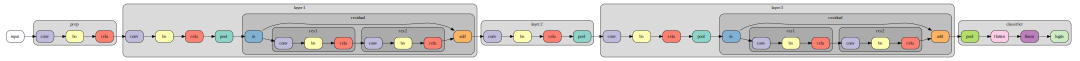

In [4]:
display(DotGraph(net()))

### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

In [ ]:
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512
cutout=8
N_runs = 5

summaries = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    model = TorchGraph(union(net(), losses)).to(device).half()
    opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
    summaries.append(train(model, lr_schedule, opt, Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)]), test_set, batch_size=batch_size, loggers=(TableLogger(),)))

test_accs = np.array([s['test acc'] for s in summaries])
print(f'mean test accuracy: {np.mean(test_accs):.4f}')
print(f'median test accuracy: {np.median(test_accs):.4f}')
print(f'{np.sum(test_accs>=0.94)}/{N_runs} >= 94%')